In [1]:
%env JAX_PLATFORM_NAME=cuda


import diffrax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from diffrax import (
    SpaceTimeLevyArea,
    SPaRK,
)


jax.config.update("jax_enable_x64", True)
jnp.set_printoptions(precision=4, suppress=True)

env: JAX_PLATFORM_NAME=cuda


# Simulating SDEs in Diffrax

We will be simulating a Stratonovich SDE of the form:
$$
    dY_t = f(Y_t, t) dt + g(Y_t, t) \circ dW_t, 
$$
where $t \in [0, T]$, $Y_t \in \mathbb{R}^e$, and $W$ is a standard Brownian motion on $\mathbb{R}^d$. We refer to $f: \mathbb{R}^e \times [0, T] \to \mathbb{R}^e$ as the drift vector field and $g: \mathbb{R}^e \times [0, T] \to \mathbb{R}^{e \times d}$ is the diffusion matrix field. The Stratonovich integral is denoted by $\circ$.

Our SDE will have the following drift and diffusion terms:
\begin{align*}
    f(Y_t, t) &= \alpha - \beta Y_t, \\
    g(Y_t, t) &= \gamma \begin{bmatrix} \Vert Y_t \Vert_2 & 0 \\ 0 & Y_{t, 1} \\ 0 & 10t \end{bmatrix},
\end{align*}
where $\alpha, \gamma \in \mathbb{R}^3$ and $\beta \in \mathbb{R}_{\geq 0}$ are some parameters.

Let's write the SDE in the form that Diffrax expects:

In [3]:
# Drift VF (e = 3)
def f(t, y, args):
    alpha, beta, gamma = args
    beta = jnp.abs(beta)
    assert alpha.shape == (3,)
    return jnp.array(alpha - beta * y, dtype=y.dtype)


# Diffusion matrix field (e = 3, d = 2)
def g(t, y, args):
    alpha, beta, gamma = args
    assert gamma.shape == y.shape == (3,)
    gamma = jnp.reshape(gamma, (3, 1))
    out = gamma * jnp.array(
        [[jnp.sqrt(jnp.sum(y**2)), 0.0], [0.0, 3 * y[0]], [0.0, 20 * t]], dtype=y.dtype
    )
    return out


# Initial condition
y0 = jnp.array([1.0, 1.0, 1.0])

# Args
alpha = 0.5 * jnp.ones((3,))
beta = 1.0
gamma = jnp.ones((3,))
args = (alpha, beta, gamma)

# Time domain
t0 = 0.0
t1 = 2.0

## Brownian motion and its Levy area

Different solvers require different information about the Brownian motion. For example, the `SPaRK` solver requires access to the space-time Levy area of the Brownian motion. The required Levy area for each solver is documented in the table at the end of this notebook, or can be checked via `solver.minimal_levy_area`.
 
We will use the `VirtualBrownianTree` class to generate the Brownian motion and its Levy area.

In [4]:
# check minimal levy area
solver = SPaRK()
print(f"Minimal levy area for SPaRK: {solver.minimal_levy_area.__name__}.")

# Brownian motion
key = jr.key(0)
bm_tol = 2**-13
bm_shape = (2,)
bm = diffrax.VirtualBrownianTree(
    t0, t1, bm_tol, bm_shape, key, levy_area=SpaceTimeLevyArea
)

# Defining the terms of the SDE
ode_term = diffrax.ODETerm(f)
diffusion_term = diffrax.ControlTerm(g, bm)  # Note that the BM is baked into the term
terms = diffrax.MultiTerm(ode_term, diffusion_term)

Minimal levy area for SPaRK: AbstractSpaceTimeLevyArea.


### Using `diffrax.diffeqsolve` to solve the SDE

We will first use constant steps of size $h = 2^{-9}$ to solve the SDE. It is very important to have $h > \mathtt{bm_tol}$, where $\mathtt{bm_tol}$ is the tolerance of the Brownian motion.

 We will use the SPaRK method to solve the SDE. ShARK is a stochastic Runge-Kutta method that requires access to space-time Levy area.

In [ ]:
dt0 = 2**-9

In [ ]:
sol = diffrax.diffeqsolve(
    terms, SPaRK(), t0, t1, dt0, y0, args, saveat=diffrax.SaveAt(steps=True)
)

# Plotting the solution on ax1 and the BM on ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol.ts, sol.ys[:, 0], label="Y_1")
ax1.plot(sol.ts, sol.ys[:, 1], label="Y_2")
ax1.plot(sol.ts, sol.ys[:, 2], label="Y_3")
ax1.set_title("SDE solution")
ax1.legend()

bm_vals = jax.vmap(lambda t: bm.evaluate(t0, t))(jnp.clip(sol.ts, t0, t1))
ax2.plot(sol.ts, bm_vals[:, 0], label="BM_1")
ax2.plot(sol.ts, bm_vals[:, 1], label="BM_2")
ax2.set_title("Brownian motion")

plt.show()

## Using adaptive time-stepping via the PID-controller

Note that the `SPaRK` solver has an embedded method for error estimation. For solvers like `GeneralShARK`, which do not have an embedded method, we'd instead need to use `HalfSolver(GeneralShARK())` as the solver.

In [ ]:
controller = diffrax.PIDController(
    rtol=0,
    atol=0.005,
    pcoeff=0.2,
    icoeff=0.5,
    dcoeff=0,
    dtmin=2**-12,
    dtmax=0.25,
)

sol_pid_spark = diffrax.diffeqsolve(
    terms,
    SPaRK(),
    t0,
    t1,
    dt0,
    y0,
    args,
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
    max_steps=2**16,
)
accepted_steps = sol_pid_spark.stats["num_accepted_steps"]
rejected_steps = sol_pid_spark.stats["num_rejected_steps"]
print(
    f"Accepted steps: {accepted_steps}, Rejected steps: {rejected_steps}, total steps: {accepted_steps + rejected_steps}"
)

# Plot the solution on ax1 and the density of ts on ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 0], label="Y_1")
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 1], label="Y_2")
ax1.plot(sol_pid_spark.ts, sol_pid_spark.ys[:, 2], label="Y_3")
ax1.set_title("SDE solution")
ax1.legend()

# Plot the density of ts
# sol_pid.ts is padded with inf values at the end, so we remove them
padding_idx = jnp.argmax(jnp.isinf(sol_pid_spark.ts))
ts = sol_pid_spark.ts[:padding_idx]
ax2.hist(ts, bins=100)
ax2.set_title("Density of ts")

plt.show()

### Using `HalfSolver(GeneralShARK())` for adaptive time-stepping

In [ ]:
half_g_shark = diffrax.HalfSolver(diffrax.GeneralShARK())

sol_pid_half_g_shark = diffrax.diffeqsolve(
    terms,
    half_g_shark,
    t0,
    t1,
    dt0,
    y0,
    args,
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
    max_steps=2**16,
)
accepted_steps = sol_pid_half_g_shark.stats["num_accepted_steps"]
rejected_steps = sol_pid_half_g_shark.stats["num_rejected_steps"]
print(
    f"Accepted steps: {accepted_steps}, Rejected steps: {rejected_steps}, total steps: {accepted_steps + rejected_steps}"
)

# Plot the solution on ax1 and the density of ts on ax2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol_pid_half_g_shark.ts, sol_pid_half_g_shark.ys[:, 0], label="Y_1")
ax1.plot(sol_pid_half_g_shark.ts, sol_pid_half_g_shark.ys[:, 1], label="Y_2")
ax1.plot(sol_pid_half_g_shark.ts, sol_pid_half_g_shark.ys[:, 2], label="Y_3")
ax1.set_title("SDE solution")
ax1.legend()

# Plot the density of ts
# sol_pid.ts is padded with inf values at the end, so we remove them
padding_idx = jnp.argmax(jnp.isinf(sol_pid_half_g_shark.ts))
ts = sol_pid_half_g_shark.ts[:padding_idx]
ax2.hist(ts, bins=100)
ax2.set_title("Density of ts")

plt.show()

## Solving an SDE for a batch of Brownian motions

When doing Monte Carlo simulations, we often need to solve the same SDE for multiple Brownian motions. We can do this via `jax.vmap`.

In [ ]:
def get_terms(bm):
    return diffrax.MultiTerm(ode_term, diffrax.ControlTerm(g, bm))


# Fix which times we step to (this is equivalent to a constant step size)
# We do this because the combination of using dt0 and SaveAt(steps=True) pads the
# output with inf values up to max_steps.
# Instead we specify exactly which times we want to save at, so Diffrax allocates
# the correct amount of memory at the outset.
num_steps = int((t1 - t0) / dt0)
step_times = jnp.linspace(t0, t1, num_steps + 1, endpoint=True)
constant_controller = diffrax.StepTo(ts=step_times)
saveat = diffrax.SaveAt(ts=step_times)


# We will vmap over keys
@jax.jit
@jax.vmap
def batch_sde_solve(key):
    bm = diffrax.VirtualBrownianTree(
        t0, t1, bm_tol, bm_shape, key, levy_area=SpaceTimeLevyArea
    )
    terms = get_terms(bm)
    return diffrax.diffeqsolve(
        terms,
        SPaRK(),
        t0,
        t1,
        None,
        y0,
        args,
        saveat=saveat,
        stepsize_controller=constant_controller,
    )


# Split the keys and compute the batched solutions
num_samples = 100
keys = jr.split(jr.PRNGKey(0), num_samples)

In [ ]:
batch_sols = batch_sde_solve(keys)
print(
    f"Shape of batch_sols: {batch_sols.ys.shape} == {num_samples} x {num_steps + 1} x (dim of Y)"
)

## Optimizing wrt. SDE parameters
A function with a similar behaviour to `batch_sde_solve` is available in `test.helpers`.

In [ ]:
from test.helpers import _batch_sde_solve

import optax
from jax import Array


bm_shape = (2,)
# Note that _batch_sde_solve doesn't output the whole solution object but just a
# tuple (ys, num_steps_output). The number of steps is there for
batch_ys, num_steps_output = _batch_sde_solve(
    keys,
    get_terms,
    bm_shape,
    t0,
    t1,
    y0,
    args,
    SPaRK(),
    SpaceTimeLevyArea,
    None,
    constant_controller,
    bm_tol,
    saveat,
    use_progress_meter=False,
)

print(
    f"Shape of batch_ys: {batch_ys.shape} == {num_samples} x {num_steps + 1} x (dim of Y)"
)
ys_t1 = batch_ys[:, -1]
mean_t1 = jnp.mean(ys_t1, axis=0)
var_t1 = jnp.mean(ys_t1**2, axis=0) - mean_t1**2
print(f"Stats at t=t1: mean={mean_t1}, var={var_t1}")


# We will optimize for achieving a mean of 0
def loss(args: tuple[Array, Array, Array]):
    batch_ys, num_steps_output = _batch_sde_solve(
        keys,
        get_terms,
        bm_shape,
        t0,
        t1,
        y0,
        args,
        SPaRK(),
        SpaceTimeLevyArea,
        2**-7,
        None,
        bm_tol,
        diffrax.SaveAt(t1=True),
        use_progress_meter=False,
    )
    assert batch_ys.shape == (num_samples, 1, 3)
    mean = jnp.mean(batch_ys, axis=(0, 1))
    std = jnp.sqrt(jnp.mean(batch_ys**2, axis=(0, 1)) - mean**2)
    target_mean = jnp.array([0.0, 1.0, 0.0])
    target_stds = 2 * jnp.ones((3,))
    loss = jnp.sqrt(
        jnp.sum((mean - target_mean) ** 2) + jnp.sum((std - target_stds) ** 2)
    )
    return loss


# Define the parameters to optimize
alpha_opt = 0.5 * jnp.ones((3,))
beta_opt = jnp.array(1.0)
gamma_opt = jnp.ones((3,))
args_opt = (alpha_opt, beta_opt, gamma_opt)

# Define the optimizer
num_steps = 191
schedule = optax.cosine_decay_schedule(3e-1, num_steps, 1e-2)
opt = optax.chain(
    optax.scale_by_adam(b1=0.9, b2=0.99, eps=1e-8),
    optax.scale_by_schedule(schedule),
    optax.scale(-1),
)
# opt = optax.adam(2e-1)
opt_state = opt.init(args_opt)


@jax.jit
def step(i, opt_state, args):
    loss_val, grad = jax.value_and_grad(loss)(args)
    updates, opt_state = opt.update(grad, opt_state)

    # One way to apply updates
    # args = optax.apply_updates(args, updates)

    # Another way to apply updates
    args = jax.tree_util.tree_map(lambda x, u: x + u, args, updates)

    return opt_state, args, loss_val


for i in range(num_steps):
    opt_state, args_opt, loss_val = step(i, opt_state, args_opt)
    alpha_opt, beta_opt, gamma_opt = args_opt
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss_val}")

print(f"Optimal parameters:\n" f"alpha={alpha_opt}, beta={beta_opt}, gamma={gamma_opt}")

In [ ]:
batch_ys_opt, num_steps_output = _batch_sde_solve(
    keys,
    get_terms,
    bm_shape,
    t0,
    t1,
    y0,
    args_opt,
    SPaRK(),
    SpaceTimeLevyArea,
    None,
    constant_controller,
    bm_tol,
    saveat,
    use_progress_meter=False,
)
ys_t1 = batch_ys_opt[:, -1]
mean_t1 = jnp.mean(ys_t1, axis=0)
var_t1 = jnp.mean(ys_t1**2, axis=0) - mean_t1**2
print(f"Stats at t=t1: mean={mean_t1}, var={var_t1}")

In [ ]:
# simulate the optimal SDE

bm = diffrax.VirtualBrownianTree(
    t0, t1, bm_tol, bm_shape, jr.key(0), levy_area=SpaceTimeLevyArea
)
terms = get_terms(bm)
sol_optimal = diffrax.diffeqsolve(
    terms,
    SPaRK(),
    t0,
    t1,
    None,
    y0,
    args_opt,
    saveat=saveat,
    stepsize_controller=constant_controller,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(sol_optimal.ts, sol_optimal.ys[:, 0], label="Y_1")
ax.plot(sol_optimal.ts, sol_optimal.ys[:, 1], label="Y_2")
ax.plot(sol_optimal.ts, sol_optimal.ys[:, 2], label="Y_3")
ax.set_title("SDE solution")
ax.legend()

plt.show()

# Table of available SRK methods in Diffrax

## Itô vs Stratonovich SDEs
Some of the solvers converge to the Itô solution of the SDE and others to the Stratonovich solution. The Itô and Stratonovich solutions coincide iff the SDE has additive noise (as defined below). For other SDEs it is possible to convert them between the Itô and Stratonovich versions using the Itô-Stratonovich correction term.


## Noise type
Depending on the type of noise (i.e. diffusion term) present in the SDE, different SRK methods have different strong orders of convergence. These types of noise are the same for Itô and Stratonovich SDEs.


### General noise
Any SDE of the form (as above):
$$
    dY_t = f(Y_t, t) dt + g(Y_t, t) dW_t, 
$$
where $t \in [0, T]$, $Y_t \in \mathbb{R}^e$, and $W$ is a standard Brownian motion on $\mathbb{R}^d$. We refer to $f: \mathbb{R}^e \times [0, T] \to \mathbb{R}^e$ as the drift vector field and $g: \mathbb{R}^e \times [0, T] \to \mathbb{R}^{e \times d}$ is the diffusion matrix field with columns $g_i$ for $i = 1, \ldots, d$.


### Commutative noise
We say that the diffusion is commutative when the columns of $g$ commute in the Lie bracket, that is
$$
   \frac{d}{dy} g_i(y, t) \;  g_j(y, t) =  g_i(y, t) \, \frac{d}{dy} g_j(y, t) \quad \forall \, y, t.
$$
For example, this holds when $g$ is diagonal or when the dimension of BM is $d=1$.


### Additive noise
We say that the diffusion is additive when $g$ does not depend on $Y_t$ and the SDE can be written as
$$
    dY_t = f(Y_t, t) dt + g(t) dW_t.
$$
Additive noise is a special case of commutative noise. For additive noise SDEs, the Itô and Stratonovich solutions conicide. Some solvers (ShARK, SRA1, SEA) are specifically designed for additive noise SDEs, so for those we do not specify whether they are Itô or Stratonovich.

In [ ]:
# +----------------+-------+------------+------------------------------------+-------------------+----------------+------------------------------------------+
# |                | SDE   | Lévy       | Strong/weak order (per noise type) | VF evaluations    | Embedded error | Recommended for                          |
# |                | type  | area       +----------+--------------+----------+-------+-----------+ estimation     | (and other notes)                        |
# |                |       |            | General  | Commutative  | Additive | Drift | Diffusion |                |                                          |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | Euler          | Itô   | BM only    | 0.5/1.0  | 0.5/1.0      | 1.0/1.0  | 1     | 1         | No             | Itô SDEs when a cheap solver is needed.  |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | Heun           | Strat | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 2     | 2         | Yes            | Standard solver for Stratonovich SDEs.   |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | EulerHeun      | Strat | BM only    | 0.5/1.0  | 0.5/1.0      | 1.0/1.0  | 1     | 2         | No             | Stratonovich SDEs with expensive drift.  |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | ItoMilstein    | Itô   | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 1     | 1         | No             | Better than Euler for Itô SDEs, but      |
# |                |       |            |          |              |          |       |           |                | comuptes the derivative of diffusion VF. |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | Stratonovich   | Strat | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 1     | 1         | No             | For commutative Stratonovich SDEs when   |
# | Milstein       |       |            |          |              |          |       |           |                | space-time Lévy area is not available.   |
# |                |       |            |          |              |          |       |           |                | Computes derivative of diffusion VF.     |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | ReversibleHeun | Strat | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 2     | 2         | Yes            | When a reversible solver is needed.      |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | Midpoint       | Strat | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 2     | 2         | Yes            | Usually Heun should be preferred.        |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | Ralston        | Strat | BM only    | 0.5/1.0  | 1.0/1.0      | 1.0/1.0  | 2     | 2         | Yes            | Usually Heun should be preferred.        |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | ShARK          | Strat | space-time | /        | /            | 1.5/2.0  | 2     | 2         | Yes            | Additive noise SDEs.                     |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | SRA1           | Strat | space-time | /        | /            | 1.5/2.0  | 2     | 2         | Yes            | Only slightly worse than ShARK.          |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | SEA            | Strat | space-time | /        | /            | 1.0/1.0  | 1     | 1         | No             | Cheap solver for additive noise SDEs.    |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | SPaRK          | Strat | space-time | 0.5/1.0  | 1.0/1.0      | 1.5/2.0  | 3     | 3         | Yes            | General SDEs when embedded error         |
# |                |       |            |          |              |          |       |           |                | estimation is needed.                    |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | GeneralShARK   | Strat | space-time | 0.5/1.0  | 1.0/1.0      | 1.5/2.0  | 2     | 3         | No             | General SDEs when embedded error         |
# |                |       |            |          |              |          |       |           |                | estimaiton is not needed.                |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+
# | SlowRK         | Strat | space-time | 0.5/1.0  | 1.5/2.0      | 1.5/2.0  | 2     | 5         | No             | Commutative noise SDEs.                  |
# +----------------+-------+------------+----------+--------------+----------+-------+-----------+----------------+------------------------------------------+

### Appendix: Using the `WeaklyDiagonalControlTerm`

Suppose we instead have $e = d = 3$ and the diffusion matrix field always returns a diagonal matrix. That is, $\forall t, y$, the matrix $g(y,t)$ is diagonal. Then we can use the `WeaklyDiagonalControlTerm`.

In [ ]:
bm2 = diffrax.VirtualBrownianTree(
    t0, t1, bm_tol, (3,), key, levy_area=SpaceTimeLevyArea
)


# Using the regular ControlTerm
def g_CT(t, y, args):
    return jnp.array(
        [[jnp.abs(jnp.sum(y)), 0.0, 0.0], [0.0, y[0], 0.0], [0.0, 0.0, 10 * t]],
        dtype=y.dtype,
    )


diffusion_term_CT = diffrax.ControlTerm(g_CT, bm2)


# The same SDE using the WeaklyDiagonalControlTerm
def g_WD(t, y, args):
    return jnp.array([jnp.abs(jnp.sum(y)), y[0], 10 * t], dtype=y.dtype)


diffusion_term_WD = diffrax.WeaklyDiagonalControlTerm(g_WD, bm2)

terms_CT = diffrax.MultiTerm(ode_term, diffusion_term_CT)
terms_WD = diffrax.MultiTerm(ode_term, diffusion_term_WD)

sol_CT = diffrax.diffeqsolve(
    terms_CT,
    SPaRK(),
    t0,
    t1,
    dt0,
    y0,
    args,
    saveat=diffrax.SaveAt(steps=True),
)
sol_WD = diffrax.diffeqsolve(
    terms_WD,
    SPaRK(),
    t0,
    t1,
    dt0,
    y0,
    args,
    saveat=diffrax.SaveAt(steps=True),
)
assert jnp.allclose(sol_CT.ys, sol_WD.ys)

# Plot the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(sol.ts, sol_WD.ys[:, 0], label="Y_1")
ax.plot(sol.ts, sol_WD.ys[:, 1], label="Y_2")
ax.plot(sol.ts, sol_WD.ys[:, 2], label="Y_3")
ax.set_title("SDE solution")
ax.legend()

plt.show()

### Unstable SDE

Num steps: constant: 2000, adaptive: 1185


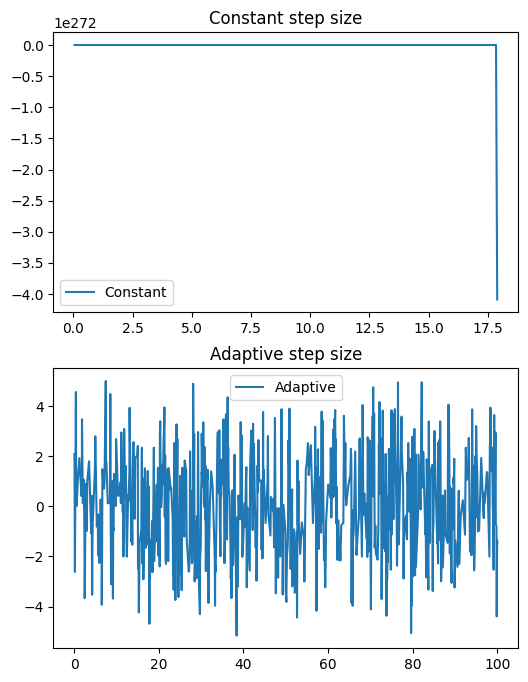

In [21]:
def f_unstable(t, y, args):
    return -(y**3)


def g_unstable(t, y, args):
    return jnp.array(10.0, dtype=y.dtype)


y0_unstable = jnp.array(0.0)

t1_unstable = 100.0

key_unstable = jr.key(0)
bm_1d = diffrax.VirtualBrownianTree(
    t0, t1_unstable, 2**-10, (), key_unstable, levy_area=SpaceTimeLevyArea
)

terms = diffrax.MultiTerm(
    diffrax.ODETerm(f_unstable),
    diffrax.ControlTerm(g_unstable, bm_1d),
)

dt_unstable = 0.05
controller = diffrax.PIDController(
    rtol=0,
    atol=10.0,
    pcoeff=0.2,
    icoeff=0.5,
    dcoeff=0,
    dtmin=2**-10,
    dtmax=0.5,
)

sol_const = diffrax.diffeqsolve(
    terms,
    SPaRK(),
    t0,
    t1_unstable,
    dt_unstable,
    y0_unstable,
    (),
    saveat=diffrax.SaveAt(steps=True),
    max_steps=2**18,
)

sol_adap = diffrax.diffeqsolve(
    terms,
    SPaRK(),
    t0,
    t1_unstable,
    dt_unstable,
    y0_unstable,
    (),
    saveat=diffrax.SaveAt(steps=True),
    stepsize_controller=controller,
    max_steps=2**18,
)

print(
    f"Num steps: constant: {sol_const.stats['num_steps']}, adaptive: {sol_adap.stats['num_steps']}"
)

# Plot each solution in a separate figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
ax1.plot(sol_const.ts, sol_const.ys, label="Constant")
ax1.set_title("Constant step size")
ax1.legend()

ax2.plot(sol_adap.ts, sol_adap.ys, label="Adaptive")
ax2.set_title("Adaptive step size")
ax2.legend()

plt.show()